In [1]:
from tempForecast.components.data_transformation import WeatherDatabase
from tempForecast.components.data_ingestion import weather_scraping


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
    ExpandingWindowFeatures
    
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

In [2]:
data = weather_scraping().load_data()
# on instancie la classe avec la base de donnée déjà chargé pour ne pas rescrapé tout
# si on met last_df en argument cela va scrapper seulement depuis la dernière date du df donc enlever pour éviter une interpolation
data_ingestion = weather_scraping(last_df=data)
# scraping 

data = data_ingestion.web_scraping()
# il faut ajouter cette base à la db
data_ingestion.load_data(df=data)
data = WeatherDatabase().load_data_and_transform()

2023-12-03 16:37:50.281212
https://www.infoclimat.fr/observations-meteo/archives/3/decembre/2023/paris-5eme-tour-zamansky-jussieu/000BV.html?dixminutes


c:\users\zbook create g7\desktop\temperature forecasting\src\tempForecast\components\data_ingestion.py:65: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  date_text = BeautifulSoup(


In [3]:
#data["unique_id"] = "temp"
data.rename(columns={"température":"y"}, inplace=True)
#data.rename(columns={"datetime":"ds"}, inplace=True)

data['y'].fillna(method='bfill', inplace=True)
data['vent'].fillna(method='bfill', inplace=True)
data['rafales'].fillna(0, inplace=True)
data['vent_direction'].fillna(0, inplace=True)
data['pt_de_rosee'].fillna(0, inplace=True)
data['humidite'].fillna(0, inplace=True)

data.drop(columns=['bio_meteo','radiation_solaire'], inplace=True)
data.drop(columns='id', inplace=True)

C:\Users\Zbook Create G7\AppData\Local\Temp\ipykernel_23596\4054969251.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['y'].fillna(method='bfill', inplace=True)
C:\Users\Zbook Create G7\AppData\Local\Temp\ipykernel_23596\4054969251.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['vent'].fillna(method='bfill', inplace=True)


In [4]:
data.isna().sum()

datetime          0
y                 0
vent              0
rafales           0
vent_direction    0
humidite          0
pt_de_rosee       0
pression          0
dtype: int64

In [5]:
# Datetime features
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "minute",
        "weekend",
    ],
)

# Lag features.

lagf = LagFeatures(
    variables=["y",'vent', 'rafales'],  # the input variables
    freq=["1H","2H"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

# Window features

winf = WindowFeatures(
    variables=["y"],  # the input variables
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month", "hour"],
    # Whether to drop the original features.
    drop_original=False,
)

# Drop original time series

drop_ts = DropFeatures(features_to_drop=["y",'vent','rafales'])

# Drop missing data
imputer = DropMissingData()

exp_w = ExpandingWindowFeatures(
    functions=["mean", "max", "std"],
    variables=['y'],
    

)

In [6]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("window", exp_w),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("drop_ts", drop_ts),
        ("dropna", imputer),

    ]
)

In [7]:
data.drop(columns='datetime', inplace=True)

In [8]:
# Split the data.

date_index = "2023-11-26 00:30:00"
# input data
X_train = data[data.index < date_index]
X_test = data[data.index >= pd.Timestamp(date_index) - pd.offsets.Hour(24)]

# target
y_train = data[data.index < date_index][["y"]]
y_test = data[data.index >= pd.Timestamp(date_index) - pd.offsets.Hour(24)][[
    "y"
]]

In [9]:
X_train.isna().sum()

y                 0
vent              0
rafales           0
vent_direction    0
humidite          0
pt_de_rosee       0
pression          0
dtype: int64

In [10]:
X_train

,y,vent,rafales,vent_direction,humidite,pt_de_rosee,pression
datetime,,,,,,,
2022-09-18 00:00:00,11.6,5.0,11.3,297.0,66.0,5.6,1020.1
2022-09-18 00:10:00,11.6,6.0,14.5,275.0,66.0,5.6,1020.1
2022-09-18 00:20:00,11.5,3.0,8.0,304.0,66.0,5.6,1020.0
2022-09-18 00:30:00,11.4,5.0,11.3,229.0,67.0,5.6,1020.0
2022-09-18 00:40:00,11.4,3.0,8.0,318.0,67.0,5.6,1020.0
...,...,...,...,...,...,...,...
2023-11-25 23:40:00,4.4,6.0,16.1,308.0,74.0,0.0,1018.6
2023-11-25 23:50:00,4.4,8.0,19.3,317.0,74.0,0.0,1018.6
2023-11-26 00:00:00,4.3,6.0,16.1,298.0,74.0,0.0,1018.5


In [11]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train[['y','vent', 'rafales']])

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,minute,weekend,y_lag_1H,vent_lag_1H,rafales_lag_1H,...,vent_lag_2H,rafales_lag_2H,y_expanding_mean,y_expanding_max,y_expanding_std,y_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2022-09-18 02:00:00,9,37,6,18,2,0,1,11.3,3.0,9.7,...,5.0,11.3,11.325000,11.6,0.195982,11.457143,-1.0,-1.836970e-16,0.519584,0.854419
2022-09-18 02:10:00,9,37,6,18,2,10,1,11.3,3.0,9.7,...,6.0,14.5,11.292308,11.6,0.221591,11.437500,-1.0,-1.836970e-16,0.519584,0.854419
2022-09-18 02:20:00,9,37,6,18,2,20,1,11.2,5.0,9.7,...,3.0,8.0,11.264286,11.6,0.237316,11.411111,-1.0,-1.836970e-16,0.519584,0.854419
2022-09-18 02:30:00,9,37,6,18,2,30,1,11.1,5.0,11.3,...,5.0,11.3,11.233333,11.6,0.258199,11.380000,-1.0,-1.836970e-16,0.519584,0.854419
2022-09-18 02:40:00,9,37,6,18,2,40,1,11.1,6.0,11.3,...,3.0,8.0,11.200000,11.6,0.282843,11.354545,-1.0,-1.836970e-16,0.519584,0.854419


In [12]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(60261, 1)
(58954, 1)


In [13]:
import lightgbm as lgb

In [14]:
X_train_t.isna().sum()

month               0
week                0
day_of_week         0
day_of_month        0
hour                0
minute              0
weekend             0
y_lag_1H            0
vent_lag_1H         0
rafales_lag_1H      0
y_lag_2H            0
vent_lag_2H         0
rafales_lag_2H      0
y_expanding_mean    0
y_expanding_max     0
y_expanding_std     0
y_window_3H_mean    0
month_sin           0
month_cos           0
hour_sin            0
hour_cos            0
dtype: int64

In [15]:
# Lasso regression

# We need a prediction for CO concentration
# and a prediction for RH.

lasso = MultiOutputRegressor(Lasso(random_state=0, alpha=1))

# Train the model

lasso.fit(X_train_t, y_train_t)

MultiOutputRegressor(estimator=Lasso(alpha=1, random_state=0))

In [16]:
# The first hour of forecast.
forecast_point = pd.Timestamp(date_index)

# The forecasting horizon (24 hs ahead)
forecast_end = forecast_point + pd.offsets.Hour(23)

forecast_point, forecast_end

(Timestamp('2023-11-26 00:30:00'), Timestamp('2023-11-26 23:30:00'))

In [17]:
# The timestamps at which we want to predict
# CO concentration.

index = pd.date_range(
    start=forecast_point,
    end=forecast_end,
    freq="10T",
)

index

DatetimeIndex(['2023-11-26 00:30:00', '2023-11-26 00:40:00',
               '2023-11-26 00:50:00', '2023-11-26 01:00:00',
               '2023-11-26 01:10:00', '2023-11-26 01:20:00',
               '2023-11-26 01:30:00', '2023-11-26 01:40:00',
               '2023-11-26 01:50:00', '2023-11-26 02:00:00',
               ...
               '2023-11-26 22:00:00', '2023-11-26 22:10:00',
               '2023-11-26 22:20:00', '2023-11-26 22:30:00',
               '2023-11-26 22:40:00', '2023-11-26 22:50:00',
               '2023-11-26 23:00:00', '2023-11-26 23:10:00',
               '2023-11-26 23:20:00', '2023-11-26 23:30:00'],
              dtype='datetime64[ns]', length=139, freq='10T')

In [18]:
# The forecasting horizon - dataframe to collect predictions

f_horizon = pd.DataFrame(columns=['y'], index=index)

f_horizon

,y
2023-11-26 00:30:00,NaN
2023-11-26 00:40:00,NaN
2023-11-26 00:50:00,NaN
2023-11-26 01:00:00,NaN
2023-11-26 01:10:00,NaN
...,...
2023-11-26 22:50:00,NaN
2023-11-26 23:00:00,NaN
2023-11-26 23:10:00,NaN
2023-11-26 23:20:00,NaN


In [19]:
# 24 hs before the first forecasting point

start_point = forecast_point - pd.offsets.Hour(24)

start_point

Timestamp('2023-11-25 00:30:00')

In [20]:
# We create input data to obtain the first prediction value.

input_data = X_test[(X_test.index >= start_point) & (X_test.index < forecast_point)]

input_data.loc[forecast_point] = np.nan

input_data

C:\Users\Zbook Create G7\AppData\Local\Temp\ipykernel_23596\1524750638.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[forecast_point] = np.nan


,y,vent,rafales,vent_direction,humidite,pt_de_rosee,pression
datetime,,,,,,,
2023-11-25 00:30:00,4.6,18.0,0.0,0,73.0,0.0,1017.6
2023-11-25 00:40:00,4.7,16.0,0.0,0,73.0,0.0,1017.5
2023-11-25 00:50:00,4.6,15.0,0.0,0,73.0,0.0,1017.6
2023-11-25 01:00:00,4.6,18.0,29.0,34.0,73.0,0.0,1017.6
2023-11-25 01:10:00,4.6,11.0,0.0,0,73.0,0.0,1017.6
...,...,...,...,...,...,...,...
2023-11-25 23:50:00,4.4,8.0,19.3,317.0,74.0,0.0,1018.6
2023-11-26 00:00:00,4.3,6.0,16.1,298.0,74.0,0.0,1018.5
2023-11-26 00:10:00,4.3,6.0,12.9,278.0,75.0,0.0,1018.5


In [21]:
# test transformation

pipe.transform(pd.DataFrame(input_data[['y','vent', 'rafales']].dropna()))

,month,week,day_of_week,day_of_month,hour,minute,weekend,y_lag_1H,vent_lag_1H,rafales_lag_1H,...,vent_lag_2H,rafales_lag_2H,y_expanding_mean,y_expanding_max,y_expanding_std,y_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2023-11-25 02:30:00,11,47,5,25,2,30,1,4.4,13.0,0.0,...,18.0,0.0,4.433333,4.7,0.187487,4.571429,-0.5,0.866025,5.195840e-01,0.854419
2023-11-25 02:40:00,11,47,5,25,2,40,1,4.3,23.0,0.0,...,16.0,0.0,4.415385,4.7,0.190815,4.537500,-0.5,0.866025,5.195840e-01,0.854419
2023-11-25 02:50:00,11,47,5,25,2,50,1,4.2,23.0,0.0,...,15.0,0.0,4.400000,4.7,0.192154,4.500000,-0.5,0.866025,5.195840e-01,0.854419
2023-11-25 03:00:00,11,47,5,25,3,0,1,4.3,16.0,0.0,...,18.0,29.0,4.373333,4.7,0.212020,4.480000,-0.5,0.866025,7.308360e-01,0.682553
2023-11-25 03:10:00,11,47,5,25,3,10,1,4.2,18.0,0.0,...,11.0,0.0,4.337500,4.7,0.250000,4.454545,-0.5,0.866025,7.308360e-01,0.682553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-25 23:40:00,11,47,5,25,23,40,1,4.5,8.0,16.1,...,8.0,14.5,5.122464,7.9,1.191026,4.723529,-0.5,0.866025,-2.449294e-16,1.000000
2023-11-25 23:50:00,11,47,5,25,23,50,1,4.5,8.0,16.1,...,6.0,11.3,5.117266,7.9,1.188284,4.700000,-0.5,0.866025,-2.449294e-16,1.000000
2023-11-26 00:00:00,11,47,6,26,0,0,1,4.4,8.0,16.1,...,8.0,16.1,5.112143,7.9,1.185553,4.670588,-0.5,0.866025,0.000000e+00,1.000000


In [22]:
input_data.isna().sum()

y                 1
vent              1
rafales           1
vent_direction    1
humidite          1
pt_de_rosee       1
pression          1
dtype: int64

In [23]:
input_data

,y,vent,rafales,vent_direction,humidite,pt_de_rosee,pression
datetime,,,,,,,
2023-11-25 00:30:00,4.6,18.0,0.0,0,73.0,0.0,1017.6
2023-11-25 00:40:00,4.7,16.0,0.0,0,73.0,0.0,1017.5
2023-11-25 00:50:00,4.6,15.0,0.0,0,73.0,0.0,1017.6
2023-11-25 01:00:00,4.6,18.0,29.0,34.0,73.0,0.0,1017.6
2023-11-25 01:10:00,4.6,11.0,0.0,0,73.0,0.0,1017.6
...,...,...,...,...,...,...,...
2023-11-25 23:50:00,4.4,8.0,19.3,317.0,74.0,0.0,1018.6
2023-11-26 00:00:00,4.3,6.0,16.1,298.0,74.0,0.0,1018.5
2023-11-26 00:10:00,4.3,6.0,12.9,278.0,75.0,0.0,1018.5


In [24]:
# Let's obtain the first prediction.

pred = lasso.predict(pipe.transform(pd.DataFrame(input_data[['y','vent', 'rafales']].dropna())))

pred

array([[4.64977751],
       [4.55253698],
       [4.45529644],
       [4.55253698],
       [4.45529644],
       [4.45529644],
       [4.45529644],
       [4.45529644],
       [4.26081537],
       [4.0663343 ],
       [4.0663343 ],
       [4.0663343 ],
       [4.16357483],
       [4.16357483],
       [4.16357483],
       [4.0663343 ],
       [4.0663343 ],
       [4.0663343 ],
       [4.16357483],
       [4.16357483],
       [4.26081537],
       [4.26081537],
       [4.26081537],
       [4.26081537],
       [4.26081537],
       [4.26081537],
       [4.16357483],
       [4.0663343 ],
       [4.0663343 ],
       [3.96909376],
       [3.96909376],
       [4.0663343 ],
       [4.0663343 ],
       [3.96909376],
       [3.87185323],
       [3.87185323],
       [3.87185323],
       [4.0663343 ],
       [4.0663343 ],
       [4.0663343 ],
       [4.16357483],
       [4.16357483],
       [4.26081537],
       [4.45529644],
       [4.55253698],
       [4.74701805],
       [4.94149912],
       [4.941

In [25]:
# Add the prediction to the horizon.

f_horizon.loc[forecast_point, "y"] = pred[0][0]

f_horizon

,y
2023-11-26 00:30:00,4.649778
2023-11-26 00:40:00,NaN
2023-11-26 00:50:00,NaN
2023-11-26 01:00:00,NaN
2023-11-26 01:10:00,NaN
...,...
2023-11-26 22:50:00,NaN
2023-11-26 23:00:00,NaN
2023-11-26 23:10:00,NaN
2023-11-26 23:20:00,NaN


In [26]:
# Add the prediction to input data.
input_data.loc[forecast_point, "y"] = pred[0][0]

input_data

,y,vent,rafales,vent_direction,humidite,pt_de_rosee,pression
datetime,,,,,,,
2023-11-25 00:30:00,4.600000,18.0,0.0,0,73.0,0.0,1017.6
2023-11-25 00:40:00,4.700000,16.0,0.0,0,73.0,0.0,1017.5
2023-11-25 00:50:00,4.600000,15.0,0.0,0,73.0,0.0,1017.6
2023-11-25 01:00:00,4.600000,18.0,29.0,34.0,73.0,0.0,1017.6
2023-11-25 01:10:00,4.600000,11.0,0.0,0,73.0,0.0,1017.6
...,...,...,...,...,...,...,...
2023-11-25 23:50:00,4.400000,8.0,19.3,317.0,74.0,0.0,1018.6
2023-11-26 00:00:00,4.300000,6.0,16.1,298.0,74.0,0.0,1018.5
2023-11-26 00:10:00,4.300000,6.0,12.9,278.0,75.0,0.0,1018.5


In [27]:
# Create forecasting horizon dataframe

# The first hour of forecast.
forecast_point = pd.Timestamp(date_index)

# The forecasting horizon.
forecast_end = forecast_point + pd.offsets.Hour(23)

# The timestamps at which we want to predict
# pollutant concentration.

index = pd.date_range(
    start=forecast_point,
    end=forecast_end,
    freq="10T",
)

# the forecasting horizon
f_horizon = pd.DataFrame(columns=["y"], index=index)

f_horizon

,y
2023-11-26 00:30:00,NaN
2023-11-26 00:40:00,NaN
2023-11-26 00:50:00,NaN
2023-11-26 01:00:00,NaN
2023-11-26 01:10:00,NaN
...,...
2023-11-26 22:50:00,NaN
2023-11-26 23:00:00,NaN
2023-11-26 23:10:00,NaN
2023-11-26 23:20:00,NaN


In [28]:
# Obtain the input data for the predictions

# 24 hs before the first forecasting point
start_point = forecast_point - pd.offsets.Hour(24)

# We create input data to obtain the first prediction value.
input_data = X_test[(X_test.index >= start_point) & (X_test.index < forecast_point)]
input_data.loc[forecast_point] = np.nan

C:\Users\Zbook Create G7\AppData\Local\Temp\ipykernel_23596\3927077873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[forecast_point] = np.nan


In [29]:
start_point

Timestamp('2023-11-25 00:30:00')

In [30]:
input_data[input_data['y'].isna()]

,y,vent,rafales,vent_direction,humidite,pt_de_rosee,pression
datetime,,,,,,,
2023-11-26 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
pipe.transform(pd.DataFrame(input_data[['y','vent', 'rafales']].dropna()))


,month,week,day_of_week,day_of_month,hour,minute,weekend,y_lag_1H,vent_lag_1H,rafales_lag_1H,...,vent_lag_2H,rafales_lag_2H,y_expanding_mean,y_expanding_max,y_expanding_std,y_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2023-11-25 02:30:00,11,47,5,25,2,30,1,4.4,13.0,0.0,...,18.0,0.0,4.433333,4.7,0.187487,4.571429,-0.5,0.866025,5.195840e-01,0.854419
2023-11-25 02:40:00,11,47,5,25,2,40,1,4.3,23.0,0.0,...,16.0,0.0,4.415385,4.7,0.190815,4.537500,-0.5,0.866025,5.195840e-01,0.854419
2023-11-25 02:50:00,11,47,5,25,2,50,1,4.2,23.0,0.0,...,15.0,0.0,4.400000,4.7,0.192154,4.500000,-0.5,0.866025,5.195840e-01,0.854419
2023-11-25 03:00:00,11,47,5,25,3,0,1,4.3,16.0,0.0,...,18.0,29.0,4.373333,4.7,0.212020,4.480000,-0.5,0.866025,7.308360e-01,0.682553
2023-11-25 03:10:00,11,47,5,25,3,10,1,4.2,18.0,0.0,...,11.0,0.0,4.337500,4.7,0.250000,4.454545,-0.5,0.866025,7.308360e-01,0.682553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-25 23:40:00,11,47,5,25,23,40,1,4.5,8.0,16.1,...,8.0,14.5,5.122464,7.9,1.191026,4.723529,-0.5,0.866025,-2.449294e-16,1.000000
2023-11-25 23:50:00,11,47,5,25,23,50,1,4.5,8.0,16.1,...,6.0,11.3,5.117266,7.9,1.188284,4.700000,-0.5,0.866025,-2.449294e-16,1.000000
2023-11-26 00:00:00,11,47,6,26,0,0,1,4.4,8.0,16.1,...,8.0,16.1,5.112143,7.9,1.185553,4.670588,-0.5,0.866025,0.000000e+00,1.000000


In [32]:
start_point

Timestamp('2023-11-25 00:30:00')

In [33]:
# And we repeat the process 23 times:

for i in range(300):
    print(i)
    # Re-slice the input data
    start_point = start_point + pd.offsets.Minute(10)
    forecast_point = forecast_point + pd.offsets.Minute(10)
    print(start_point)
    print(forecast_point)
    input_data = input_data[(input_data.index >= start_point)]
    print(input_data)
    input_data.loc[forecast_point] = np.nan
    print(input_data)
    # Obtain the prediction
    pred = lasso.predict(pipe.transform(pd.DataFrame(input_data[['y','vent', 'rafales']].dropna())))
    # Add prediction to horizon.
    f_horizon.loc[forecast_point, 'y'] = pred[0][0]
    input_data.loc[forecast_point, 'y'] = pred[0][0]
    print("iiii")
f_horizon

0
2023-11-25 00:40:00
2023-11-26 00:40:00
                       y  vent  rafales vent_direction  humidite  pt_de_rosee  \
datetime                                                                        
2023-11-25 00:40:00  4.7  16.0      0.0              0      73.0          0.0   
2023-11-25 00:50:00  4.6  15.0      0.0              0      73.0          0.0   
2023-11-25 01:00:00  4.6  18.0     29.0           34.0      73.0          0.0   
2023-11-25 01:10:00  4.6  11.0      0.0              0      73.0          0.0   
2023-11-25 01:20:00  4.5  10.0     22.5           22.0      74.0          0.0   
...                  ...   ...      ...            ...       ...          ...   
2023-11-25 23:50:00  4.4   8.0     19.3          317.0      74.0          0.0   
2023-11-26 00:00:00  4.3   6.0     16.1          298.0      74.0          0.0   
2023-11-26 00:10:00  4.3   6.0     12.9          278.0      75.0          0.0   
2023-11-26 00:20:00  4.3   6.0     14.5          220.0      75.0   

ValueError: Found array with 0 sample(s) (shape=(0, 21)) while a minimum of 1 is required by Lasso.

In [34]:
f_horizon

,y
2023-11-26 00:30:00,NaN
2023-11-26 00:40:00,4.552537
2023-11-26 00:50:00,4.455296
2023-11-26 01:00:00,4.552537
2023-11-26 01:10:00,4.455296
...,...
2023-11-26 22:50:00,NaN
2023-11-26 23:00:00,NaN
2023-11-26 23:10:00,NaN
2023-11-26 23:20:00,NaN


In [35]:
# We can plot our predictions vs. the truth, which is
# the CO concentration in the test set.

tmp = pd.DataFrame(f_horizon["y"]).join(
    X_test["y"], lsuffix="_left", rsuffix="_right")

tmp.columns = ["predicted", "actual"]

tmp

,predicted,actual
2023-11-26 00:30:00,NaN,4.3
2023-11-26 00:40:00,4.552537,4.3
2023-11-26 00:50:00,4.455296,4.2
2023-11-26 01:00:00,4.552537,4.3
2023-11-26 01:10:00,4.455296,4.2
...,...,...
2023-11-26 22:50:00,NaN,4.8
2023-11-26 23:00:00,NaN,4.8
2023-11-26 23:10:00,NaN,4.7
2023-11-26 23:20:00,NaN,4.6


Text(0, 0.5, 'temperature')

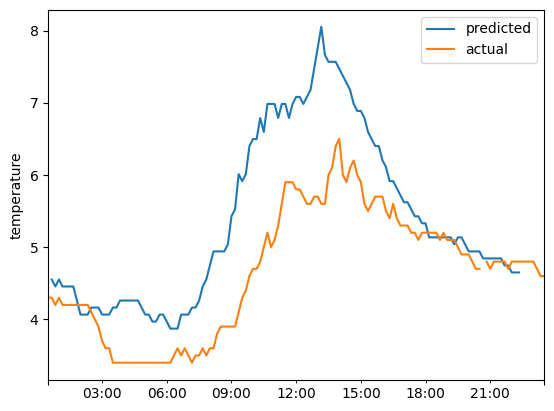

In [36]:
tmp.plot()
plt.ylabel("temperature")

Text(0, 0.5, 'temperature')

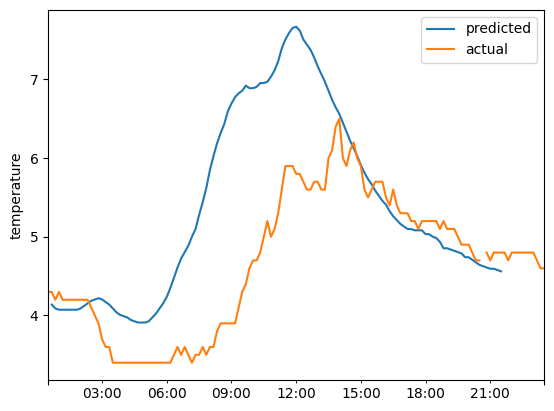

In [ ]:
tmp.plot()
plt.ylabel("temperature")

In [37]:
tmp['actual'].fillna(method='bfill', inplace=True)

C:\Users\Zbook Create G7\AppData\Local\Temp\ipykernel_23596\3359853178.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp['actual'].fillna(method='bfill', inplace=True)


In [38]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [39]:
mae =  mean_absolute_error(tmp.dropna()['predicted'], tmp.dropna()['actual'])
mape =  mean_absolute_percentage_error(tmp.dropna()['predicted'], tmp.dropna()['actual'])
mae, mape

(0.7399883668028726, 0.1292381126736371)

In [ ]:
mae =  mean_absolute_error(tmp.dropna()['predicted'], tmp.dropna()['actual'])
mape =  mean_absolute_percentage_error(tmp.dropna()['predicted'], tmp.dropna()['actual'])
mae, mape

(0.7453401343489882, 0.13016197279321406)

In [40]:
tmp['predicted'].fillna(tmp['predicted'].mean())

2023-11-26 00:30:00    5.383164
2023-11-26 00:40:00    4.552537
2023-11-26 00:50:00    4.455296
2023-11-26 01:00:00    4.552537
2023-11-26 01:10:00    4.455296
                         ...   
2023-11-26 22:50:00    5.383164
2023-11-26 23:00:00    5.383164
2023-11-26 23:10:00    5.383164
2023-11-26 23:20:00    5.383164
2023-11-26 23:30:00    5.383164
Freq: 10T, Name: predicted, Length: 139, dtype: float64

In [41]:
mae =  mean_absolute_error(tmp['predicted'].fillna(tmp['predicted'].mean()), tmp['actual'].fillna(tmp['actual'].mean()))
mape =  mean_absolute_percentage_error(tmp['predicted'].fillna(tmp['predicted'].mean()), tmp['actual'].fillna(tmp['actual'].mean()))
mae, mape

(0.7381567573064496, 0.1293712661727459)

In [35]:
from tempForecast.components.pipeline_transformation import pipe

In [40]:
a = WeatherDatabase().split_train_test(pd.read_csv("C:/Users/Zbook Create G7/Desktop/temperature forecasting/artifacts/data_ingestion/data.csv"))

In [43]:
a

(Empty DataFrame
 Columns: [y, vent, rafales, vent_direction, humidite, pt_de_rosee, pression]
 Index: [],
                                  y  vent  rafales  vent_direction  humidite  \
 1970-01-01 00:00:00.000000000  8.8  10.0     22.5           159.0      89.0   
 1970-01-01 00:00:00.000000001  8.6  11.0     27.4           207.0      90.0   
 1970-01-01 00:00:00.000000002  8.5  15.0      0.0             0.0      91.0   
 1970-01-01 00:00:00.000000003  8.4  13.0     29.0           145.0      91.0   
 1970-01-01 00:00:00.000000004  8.3  16.0      0.0             0.0      92.0   
 ...                            ...   ...      ...             ...       ...   
 1970-01-01 00:00:00.000000107  6.1  24.0      0.0             0.0      89.0   
 1970-01-01 00:00:00.000000108  6.1  24.0      0.0             0.0      89.0   
 1970-01-01 00:00:00.000000109  6.0  29.0      0.0             0.0      89.0   
 1970-01-01 00:00:00.000000110  6.0  29.0      0.0             0.0      89.0   
 1970-01-01 0